# querying Aris from CasJobs : Count objects in low-level HEALPix cells

Prerequisites:

* pip install healpy

In [19]:
import SciServer.CasJobs as cj
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import healpy
import numpy as np
from datetime import datetime

In [20]:
LSST="LSST_aris"
# code for perfect(unit?) sphere
SRID=104001

## count Object rows in HEALPix cells at level LEVEL
Various different version of table used

In [21]:
%%time
#
# use temptable #a iso defining it inside CTE, as otherwise it will be executed multiple times in the union
#
def queryHEALPixCounts(object_table,level):
    print("[",datetime.now(),"] table:",object_table,", level:",level)
    pow=20-level
    sql="""
select healpixid/power(4,{pow}) as healpixid_L, count(*) as num
  from {object_table}
 group by  healpixid/power(4,{pow}) 
 order by 1
    """.format(pow=20-level,object_table=object_table)
    return cj.executeQuery(sql,LSST)

CPU times: user 22 µs, sys: 11 µs, total: 33 µs
Wall time: 64.4 µs


In [22]:
ORDER=5
NSIDE=2**ORDER

In [12]:
%time healpix5_dp_test=queryHEALPixCounts('dp.Object_test',ORDER)


[ 2020-01-28 11:27:27.921407 ] table: dp.Object_test , level: 5
CPU times: user 38.5 ms, sys: 8.44 ms, total: 47 ms
Wall time: 8.84 s


In [13]:
healpix5_dp_test.sum()

healpixid_L      95028
num            2108307
dtype: int64

# Plotting

In [14]:
hpmap=np.full(healpy.nside2npix(NSIDE), healpy.UNSEEN)
hpmap[healpix5_dp_test['healpixid_L']]=healpix5_dp_test['num']

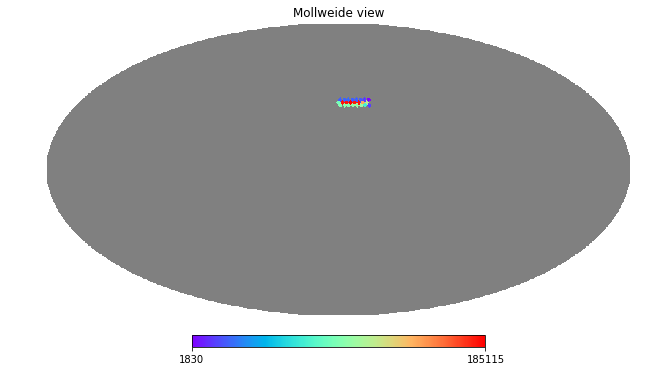

In [15]:
healpy.mollview(hpmap,cmap='rainbow',badcolor='grey',nest=True)

In [16]:
sql="""
select top 100000 ra,decl
  from dp.Object_test
  order by newid()
"""
df=cj.executeQuery(sql,LSST)

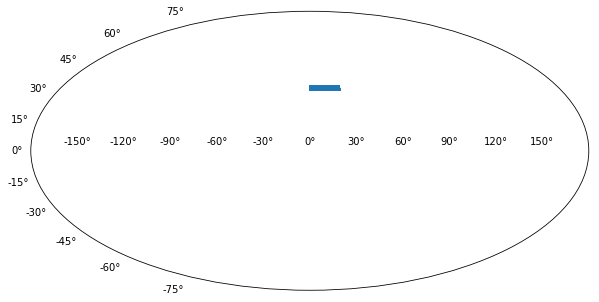

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='mollweide')
lon=-np.deg2rad(df['ra']+180)% (2 * np.pi) - np.pi
lat=np.deg2rad(df['decl'])
im = ax.scatter(lon,lat,s=1)

In [29]:
%%time
#
# use temptable #a iso defining it inside CTE, as otherwise it will be executed multiple times in the union
#
def queryHEALPixCountsAsync(object_table,level,mydbtable):
    print("[",datetime.now(),"] table:",object_table,", level:",level)
    pow=20-level
    sql="""
select healpixid/power(4,{pow}) as healpixid_L, count(*) as num
  into {mydbtable}
  from {object_table}
 group by  healpixid/power(4,{pow}) 
 order by 1
    """.format(pow=20-level,object_table=object_table,mydbtable=mydbtable)
    return cj.submitJob(sql,LSST)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 32.7 µs


In [30]:
jobid=queryHEALPixCountsAsync('dp.Object',ORDER,"my_dp_Object")
r=cj.waitForJob(jobid,verbose=True)


[ 2020-01-28 21:43:41.768915 ] table: dp.Object , level: 5
Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...Waiting...W

In [39]:
r

{'JobID': 46529085,
 'Rows': 10662,
 'WebServicesID': 999687452,
 'TimeSubmit': '2020-01-28T16:43:43.75',
 'TimeStart': '2020-01-28T16:43:51.78',
 'TimeEnd': '2020-01-28T17:06:12.973',
 'SendEmail': 0,
 'Status': 5,
 'AutoComplete': 0,
 'Estimate': 500,
 'TaskName': 'Compute.SciScript-Python.CasJobs.submitJob',
 'OutputLoc': '',
 'HostIP': 'LSST_Aris_long ',
 'Message': 'Query Complete',
 'Query': '\nselect healpixid/power(4,15) as healpixid_L, count(*) as num\n  into my_dp_Object\n  from dp.Object\n group by  healpixid/power(4,15) \n order by 1\n    ',
 'ModifiedQuery': 'select healpixid/power(4,15) as healpixid_L, count(*) as num\n  \n  from dp.Object\n group by  healpixid/power(4,15) \n order by 1/*CASJOBS_INTO_TABLE:[mydbsql].mydb_999687452.webuser.my_dp_Object*/',
 'Target': 'LSST_aris',
 'OutputType': 'QUERY',
 'Params': '{\r\n  "token": "bb0845f82efe4166af4456f97289439d"\r\n}',
 'Created_Table': 'my_dp_Object'}

In [32]:
df=cj.executeQuery("select * from my_dp_object order by 1","MyDB")

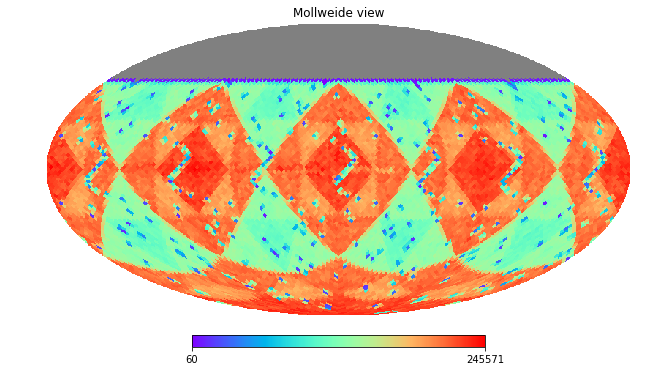

In [35]:
hpmap=np.full(healpy.nside2npix(NSIDE), healpy.UNSEEN)
hpmap[df['healpixid_L']]=df['num']
healpy.mollview(hpmap,cmap='rainbow',badcolor='grey',nest=True)

In [37]:
%time healpix5_cci=queryHEALPixCounts('m_Object_cci',ORDER)
# NO index on healpixid!

[ 2020-01-28 22:32:50.647031 ] table: m_Object_cci , level: 5
CPU times: user 67.2 ms, sys: 19.6 ms, total: 86.8 ms
Wall time: 54.4 s


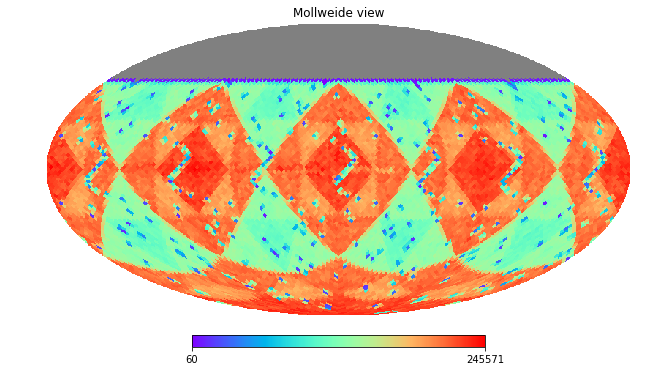

In [38]:
hpmap=np.full(healpy.nside2npix(NSIDE), healpy.UNSEEN)
hpmap[healpix5_cci['healpixid_L']]=healpix5_cci['num']
healpy.mollview(hpmap,cmap='rainbow',badcolor='grey',nest=True)